# Ablation Study from "Rotate your Networks: Better Weight Consolidation and Less Catastrophic Forgetting", ICPR 2018

This is our implementation of Elastic Weight Consolidation (EWC) in Tensorflow, which also allows to choose which layers use our proposed R-EWC modification, as seen in Table I of the article. The variable below is used to decide which layers of the LeNet network apply EWC (False), or our extended R-EWC (True).

In [1]:
rotate_layer = [True, True, True, True, False]

## Train LeNet for Disjoint MNIST tasks sequentially

In [2]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
from copy import deepcopy

from utils.lenet_utils import LeNet
from utils import mnist_utils
from utils import plot_utils

In [4]:
def train_task(sess, model, num_epochs, trainset, testsets, x, y_, lr, batch_size=100):

    num_batch = int(np.floor(trainset.train.images.shape[0]/batch_size))
    
    # Reassign optimal weights from previous training session
    model.restore(sess)
    # Initialize test accuracy array for each task
    test_accs = []
    for task in range(len(testsets)):
        test_accs.append(np.zeros(num_epochs))
    # Train on current task
    for epoch in range(num_epochs):
        img = np.random.permutation(trainset.train.images.shape[0]) 
        for b in range(num_batch):
            # randomly sample a batch of images, and corresponding labels
            batch_x = trainset.train.images[img[b*batch_size:(b+1)*batch_size]]
            batch_y = trainset.train.labels[img[b*batch_size:(b+1)*batch_size]]
            one_hot_targets = np.eye(10)[batch_y]
            # train batch
            model.train_step.run(feed_dict={x: batch_x, y_: one_hot_targets})
        # Plotting
        plt.subplot(1, 1, 1)
        plots = []
        colors = ['r', 'b']
        for task in range(len(testsets)):
            feed_dict={x: testsets[task].test.images, y_: np.eye(10)[testsets[task].test.labels]}
            test_accs[task][epoch] = model.accuracy.eval(feed_dict=feed_dict)
            c = chr(ord('A') + task)
            plot_h, = plt.plot(range(1,epoch+2), test_accs[task][:epoch+1], colors[task], label="task " + c + " (%1.2f)" % test_accs[task][epoch])
            plots.append(plot_h)
        plot_utils.plot_test_acc(plots)
        plt.gcf().set_size_inches(10, 7)

    return test_accs

In [5]:
# Load the dataset and create the two groups of Disjoint MNIST
mnist = mnist_utils.load_mnist_32x32()

task1_num = [0,1,2,3,4]
mnist1 = mnist_utils.disjoint_mnist(mnist, task1_num)
print("MNIST-1 Image Shape: {}".format(mnist1.train.images[0].shape))
print("MNIST-1 Labels: {}".format(np.unique(mnist1.train.labels)))

task2_num = [5,6,7,8,9]
mnist2 = mnist_utils.disjoint_mnist(mnist,task2_num)
print("MNIST-2 Labels: {}".format(np.unique(mnist2.train.labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples
Labels: [7 3 4 ... 5 6 8]
Original Image Shape: (28, 28, 1)
Updated Image Shape: (32, 32, 1)
MNIST-1 Image Shape: (32, 32, 1)
MNIST-1 Labels: [0 1 2 3 4]
MNIST-2 Labels: [5 6 7 8 9]


In [6]:
# Set Parameters
num_epochs0 = 5
num_epochs1 = 5
meta_lambda = 100
num_samples = 40  #number of samples per class
lr = 0.001

In [7]:
tf.reset_default_graph()
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# instantiate new model
model = LeNet(x, y_, doDecom = rotate_layer)
model.set_vanilla_loss(lr)
# initialize variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train on task 1, test on task 1

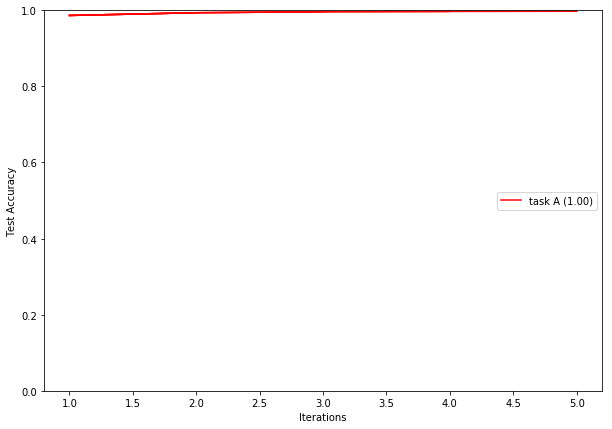

In [8]:
# training 1st task
test_accs0 = train_task(sess, model, num_epochs0, mnist1, [mnist1], x, y_, lr)
model.star()

## Apply EWC or R-EWC

In [9]:
# Compute the M and L matrices as described in the article, and use them to calculate the rotations
model.compute_M_L(mnist1.validation, sess, num_samples, eq_distrib=True)
model.compute_svd(sess)

In [10]:
tf.reset_default_graph()
# Define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
sess = tf.InteractiveSession()
# Construct a new model
model.rebuild_decom(x, y_)
# Initialize variables
sess.run(tf.global_variables_initializer())
model.star()
# Compute the Fisher Information necessary for the EWC loss term
model.compute_fisher(mnist1.validation, sess, num_samples, eq_distrib=True)

In [11]:
tf.reset_default_graph()
# Define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# Construct a new model
model.rebuild_decom(x, y_)
model.update_ewc_loss(lr, meta_lambda, 5)
# Initialize variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train on task 1, test on tasks 1 and 2

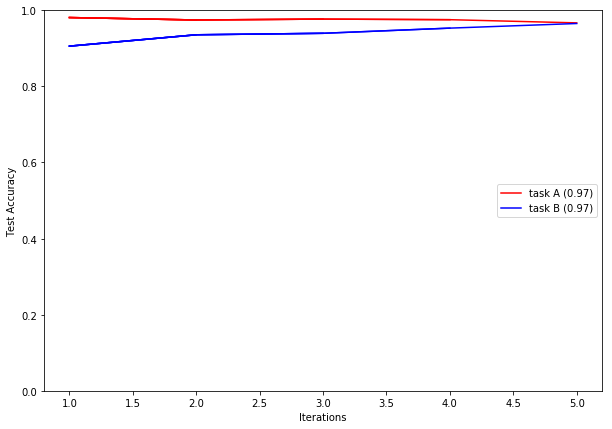

In [12]:
# training 2nd task
test_accs1 = train_task(sess, model, num_epochs1, mnist2, [mnist1, mnist2], x, y_, lr)